<a href="https://colab.research.google.com/github/YuvanBharathi13/DeepLearning/blob/main/Food_Vission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD VISION

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sun Jun 22 14:58:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Mixed Precision

- In this project we will be using Mixed precision.
- Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.
- Mixed precsion can run on any hardware but it will only speed up models on recent NVIDIA GPUs which have a compute power greater or equal to 7.0.
- lucky for us, colab gives access to NVIDIA T4 GPU which has a compute power of 7.5. yayyy!!!

## Helper functions

- These are the function we would be using throughout the project

In [3]:
def plot_curves(history):
  loss_train = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)

  plt.plot(epochs,loss_train,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)

  plt.plot(epochs,accuracy,'r',label='Training Accuracy')
  plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Downloading Dataset

- For this project we will be working on the food101 dataset from tensorflow datasets.
- it is a dataset that contains data for 101 food classes with each class having 750 training images and 250 testing images.

In [5]:
import tensorflow_datasets as tfds

In [42]:
(train_data,test_data), ds_info = tfds.load(name='food101',
                                            split=['train','validation'],
                                            shuffle_files=True, # shuffles the images as it downloads
                                            as_supervised=True, # the dataset will come with the labels (data,label)
                                            with_info=True) # we are downloading the meta data as well

## Exploring the Dataset

- Questions that need to be asked -
  1. The shape of our input data (image tensors)
  2. The datatype of our input data
  3. What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
  4. Do the labels match up with the class names?

In [43]:
print(type(train_data))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [44]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names
class_names[10:20]

['bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [10]:
print('pizza' in class_names)

True


In [11]:
train_data.element_spec # The reason why our image size is (none,none,3) is because they all dont have the same shape

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [12]:
sample_image_tuple = train_data.take(1)
sample_image_tuple # will return a random image each time you run it

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# uint8 stands for unsigned 8-bit integer. It’s a data type commonly used to represent image pixel values.

In [14]:
import matplotlib.image as mpimg

(384, 512, 3)
<dtype: 'uint8'>
tf.Tensor(56, shape=(), dtype=int64)
huevos_rancheros


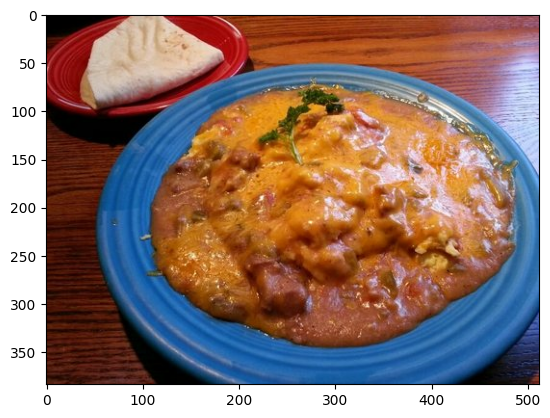

In [49]:
for image, label in sample_image_tuple:
  print(image.shape)
  print(image.dtype)
  print(label)
  print(class_names[label.numpy()]) # since it is tensor we convert it to a numpy variable
  plt.imshow(image)
  plt.show()

In [16]:
image # all values between 0-255

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

## Data pre-processing

- Things we need to change in our dataset
  1. Our data is not scaled so we need to scale it
  2. The datatype has to be in float as models perform better on it and our current dtype is uint8.
  3. The train and test data are not in batches, so they need to be wrapped in batches
  4. and all the images have different shapes so we need to make then into (224,224,3)

In [46]:
def pre_process_img(image,label,img_shape=224):
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

Shape of the image before was (382, 512, 3)
Datatype of the image before was <dtype: 'uint8'>
Shape of the image is (224, 224, 3)
Datatype of the image is <dtype: 'float32'>


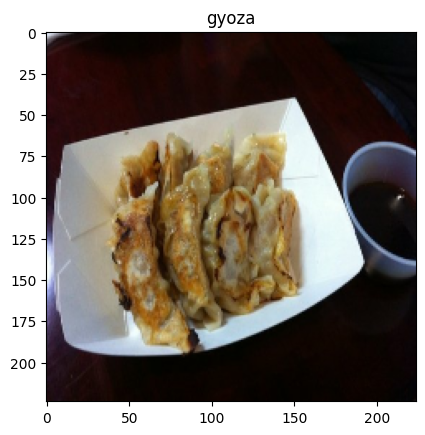

In [50]:
for image, label in sample_image_tuple:
  print(f"Shape of the image before was {image.shape}")
  print(f"Datatype of the image before was {image.dtype}")
  image, label = pre_process_img(image,label)
  print(f"Shape of the image is {image.shape}")
  print(f'Datatype of the image is {image.dtype}')
  plt.imshow(image/255)
  plt.title(class_names[label.numpy()])

## Batch and prepare dataset

In [51]:
# Train data
train_data = train_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Test data
test_data = test_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating callbacks

In [66]:
path = 'model_check_point/feature_extraction_model_weights.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      save_freq='epoch')

## Set up mixed precision training

- mixed precision uses a combination of float16 and float32 to speed up the model.
- using mixed precision could speed up our model by 3 times on GPU's with a compute capability greater than 7.

In [67]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Feature extraction model

- calculations are done in float16 while the weights are finally stored in float32 for numeric stability.

In [68]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3),name='input_layer')
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='average_pooling_layer')(x)
x = tf.keras.layers.Dense(len(class_names),name='Output_dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax',dtype='float32',name='output_softmax_layer')(x)
model = tf.keras.Model(inputs,outputs)

In [69]:
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are not one-hot encoded,
              optimizer='Adam',
              metrics=['accuracy'])

In [70]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_dense_layer (Dense)      │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_11 (Cast)                  │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_layer            │ (None, 101)            │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [63]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
average_pooling_layer True float32 <DTypePolicy "mixed_float16">
Output_dense_layer True float32 <DTypePolicy "mixed_float16">
output_softmax_layer True float32 <DTypePolicy "float32">


In [64]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_5 False float32 <DTypePolicy "mixed_float16">
rescaling_5 False float32 <DTypePolicy "mixed_float16">
normalization_5 False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_exp

In [71]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
model_feature_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 196s 71ms/step - accuracy: 0.4579 - loss: 2.3561 - val_accuracy: 0.6962 - val_loss: 1.1643
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 198s 75ms/step - accuracy: 0.6547 - loss: 1.3423 - val_accuracy: 0.7214 - val_loss: 1.0444
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 181s 66ms/step - accuracy: 0.6885 - loss: 1.1916 - val_accuracy: 0.7309 - val_loss: 1.0030
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 154s 64ms/step - accuracy: 0.7116 - loss: 1.0955 - val_accuracy: 0.7402 - val_loss: 0.9639
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 260s 88ms/step - accuracy: 0.7262 - loss: 1.0344 - val_accuracy: 0.7394 - val_loss: 0.9692


In [72]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 54s 68ms/step - accuracy: 0.7377 - loss: 0.9660


[0.9649704694747925, 0.7359604239463806]

In [78]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = False

  # Create Functional model
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [ ]:
# 2. Create and compile a new version of the original model (new weights)
model_fine_tuned = create_model()
model_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
model_fine_tuned.load_weights("/content/model_check_point/feature_extraction_model_weights.weights.h5")

# 4. Evaluate the model with loaded weights
model_fine_tuned.evaluate(test_data)

105/790 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.7302 - loss: 0.9980